<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Text_Detection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! git clone https://github.com/eriklindernoren/PyTorch-YOLOv3

In [2]:
#cd PyTorch-YOLOv3/

In [3]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
assert torch.__version__.startswith('1.7')
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Run on a smaple Image 

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [7]:
!ls
%cd My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition

'My Drive'
/gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition


In [8]:
!ls

 Annotation   Images   input.jpg   readme.txt  'Test Image'


# Unzip the Custom Data

In [9]:
#!unzip 'Synthetic Train Set - Detection & Recognition.zip'

# Store Data in Detectron2 format 

In [10]:
from detectron2.structures import BoxMode

def get_text_dicts(img_dir,annot_directory,view_data = False):
    print("annot_directory",annot_directory)
    
     ## read a text File ## 
    if view_data:
      all_text_files = os.listdir(annot_directory)[:4]
    else:
      all_text_files = os.listdir(annot_directory)[0:100]
    #print("all_text_files",all_text_files)

    dataset_dicts = []
    for e_file in all_text_files:
        record = {}
        
        filename = os.path.join(img_dir, e_file.replace('.txt','.jpg'))
        #print("filename",filename)
        try:
          height, width = cv2.imread(filename).shape[:2]
        except:
          continue
        
        record["file_name"] = filename
        record["image_id"] = e_file.strip('.txt')
        record["height"] = height
        record["width"] = width
      
        objs = []
        annot_file_name = os.path.join(annot_directory,e_file)
        with open(annot_file_name,'r') as fh:
            all_lines = fh.readlines()
        
        fh.close()
        for e_line in all_lines:
         # print(e_line)
          split_list = e_line.split(' ')
          px = [float(e_str) for e_str in split_list[0:4]]
          py = [float(e_str) for e_str in split_list[4:8]]
          poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
          poly = [p for x in poly for p in x]
          obj = {
              "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": 0,
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [11]:
# for i in ["Train","Val"]:
#   if i == "Train":
#     ## Train 23 Folders of 25 ##
#     d = 24
#     DatasetCatalog.register("TextIdentifier_" +"Train", lambda d=d: [get_text_dicts("./Images/"+str(e_f),"./Annotation/"+str(e_f)) for e_f in range(1,d)])
#     MetadataCatalog.get("TextIdentifier_" +"Train").set(thing_classes=["Text"])
#   else:
#     DatasetCatalog.register("TextIdentifier_" +"Val", lambda d=d: [get_text_dicts("./Images/"+str(e_f),"./Annotation/"+str(e_f)) for e_f in range(d,26)])
#     MetadataCatalog.get("TextIdentifier_" +"Val").set(thing_classes=["Text"])




In [12]:
for d in range(1,24):
  d = str(d)
  DatasetCatalog.register("TextIdentifier_" +d, lambda d=d: get_text_dicts("./Images/"+d,"./Annotation/"+d))
  MetadataCatalog.get("TextIdentifier_" +d).set(thing_classes=["Text"])
  # else:
  #   DatasetCatalog.register("TextIdentifier_" +"Val", lambda d=d: [get_text_dicts("./Images/"+str(e_f),"./Annotation/"+str(e_f)) for e_f in range(d,26)])
  #   MetadataCatalog.get("TextIdentifier_" +"Val").set(thing_classes=["Text"])




In [13]:
TextIdentifier_meta = MetadataCatalog.get("TextIdentifier_train")
print(TextIdentifier_meta)


Metadata(name='TextIdentifier_train')


In [13]:
import re
all_datasets = list(DatasetCatalog.data.keys())
pattern = re.compile("TextIdentifier")

custom_dataset = (e_dataset for e_dataset in all_datasets if re.match(pattern,e_dataset)!=None)
custom_dataset = tuple(custom_dataset)
print("custom_dataset",custom_dataset)

custom_dataset ('TextIdentifier_1', 'TextIdentifier_2', 'TextIdentifier_3', 'TextIdentifier_4', 'TextIdentifier_5', 'TextIdentifier_6', 'TextIdentifier_7', 'TextIdentifier_8', 'TextIdentifier_9', 'TextIdentifier_10', 'TextIdentifier_11', 'TextIdentifier_12', 'TextIdentifier_13', 'TextIdentifier_14', 'TextIdentifier_15', 'TextIdentifier_16', 'TextIdentifier_17', 'TextIdentifier_18', 'TextIdentifier_19', 'TextIdentifier_20', 'TextIdentifier_21', 'TextIdentifier_22', 'TextIdentifier_23')


# View Sample Data 

annot_directory ./Annotation/21


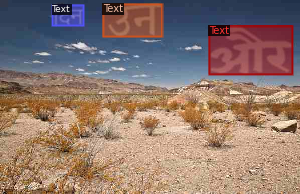

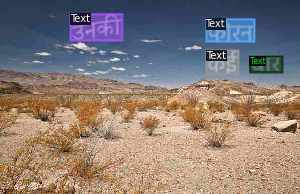

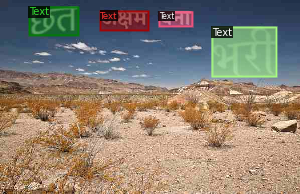

In [14]:
dd = str(np.random.randint(1,25))
TextIdentifier_MData = MetadataCatalog.get("TextIdentifier_"+dd)
dataset_dicts = get_text_dicts("./Images/"+dd,"./Annotation/"+dd,view_data=True)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=TextIdentifier_MData, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Pre-Train Model With CoCo Set & Train with Custom Set

In [15]:
cfg = get_cfg()

In [16]:
from detectron2.engine import DefaultTrainer


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = custom_dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good Learning Rate
cfg.SOLVER.MAX_ITER = 1000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   #(default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class ("Text"). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)
trainer.train()

[11/15 19:26:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[11/15 19:27:10 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/

[11/15 19:27:20 d2.utils.events]:  eta: 0:08:00  iter: 19  total_loss: 1.956  loss_cls: 0.6688  loss_box_reg: 0.2014  loss_mask: 0.6922  loss_rpn_cls: 0.2827  loss_rpn_loc: 0.03066  time: 0.4827  data_time: 0.0147  lr: 4.9953e-06  max_mem: 2617M
[11/15 19:27:30 d2.utils.events]:  eta: 0:08:15  iter: 39  total_loss: 1.825  loss_cls: 0.6176  loss_box_reg: 0.1555  loss_mask: 0.6863  loss_rpn_cls: 0.2709  loss_rpn_loc: 0.03959  time: 0.5046  data_time: 0.0056  lr: 9.9902e-06  max_mem: 2672M
[11/15 19:27:41 d2.utils.events]:  eta: 0:08:12  iter: 59  total_loss: 1.66  loss_cls: 0.5384  loss_box_reg: 0.1517  loss_mask: 0.6736  loss_rpn_cls: 0.2636  loss_rpn_loc: 0.03478  time: 0.5187  data_time: 0.0052  lr: 1.4985e-05  max_mem: 2756M
[11/15 19:27:52 d2.utils.events]:  eta: 0:08:03  iter: 79  total_loss: 1.825  loss_cls: 0.4778  loss_box_reg: 0.3208  loss_mask: 0.6586  loss_rpn_cls: 0.2618  loss_rpn_loc: 0.04021  time: 0.5228  data_time: 0.0066  lr: 1.998e-05  max_mem: 2756M
[11/15 19:28:02 d2

# Training Plots

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model


In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

./output/model_final.pth


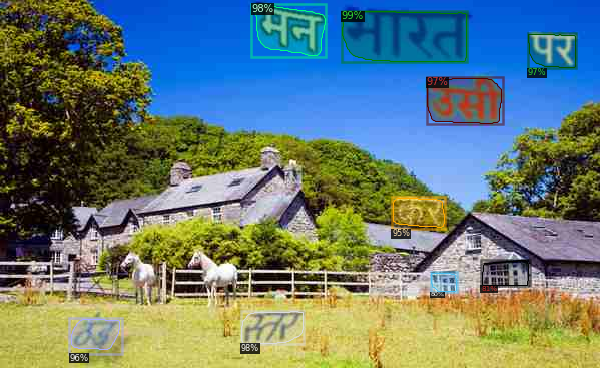

In [23]:
all_test_images = os.listdir(r"./Images/25")
for i in range(1):    
  ind = random.randint(0,len(all_test_images))
  file_name = all_test_images[ind]
  full_path = os.path.join("./Images/25",file_name)
  inputs = cv2.imread(full_path)
  #print(inputs)
  outputs = predictor(inputs)
#predictor = DefaultPredictor(cfg)
#print("outputs",outputs)
from detectron2.utils.visualizer import ColorMode
v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

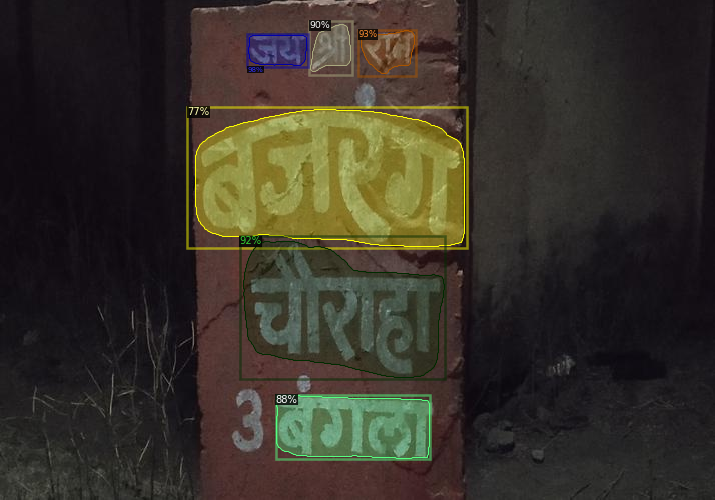

In [27]:
all_test_images = os.listdir(r"./Test Image")
for i in range(1):    
  ind = random.randint(0,len(all_test_images))
  file_name = all_test_images[ind]
  full_path = os.path.join("./Test Image",file_name)
  inputs = cv2.imread(full_path)
  #print(inputs)
  outputs = predictor(inputs)
#predictor = DefaultPredictor(cfg)
#print("outputs",outputs)
from detectron2.utils.visualizer import ColorMode
v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])